In [ ]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [ ]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="sam_vit_h_4b8939.pth"))

In [ ]:
image_path = "isaid_segm/val/images/images/P0003.png"

In [ ]:
image = cv2.imread(image_path)
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [ ]:
Image.fromarray(image)

In [ ]:
for mask in masks:
    print(mask)

In [31]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [53]:
def add_segment(result, image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    result.paste(black_image, mask=transparency_mask_image)

In [ ]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

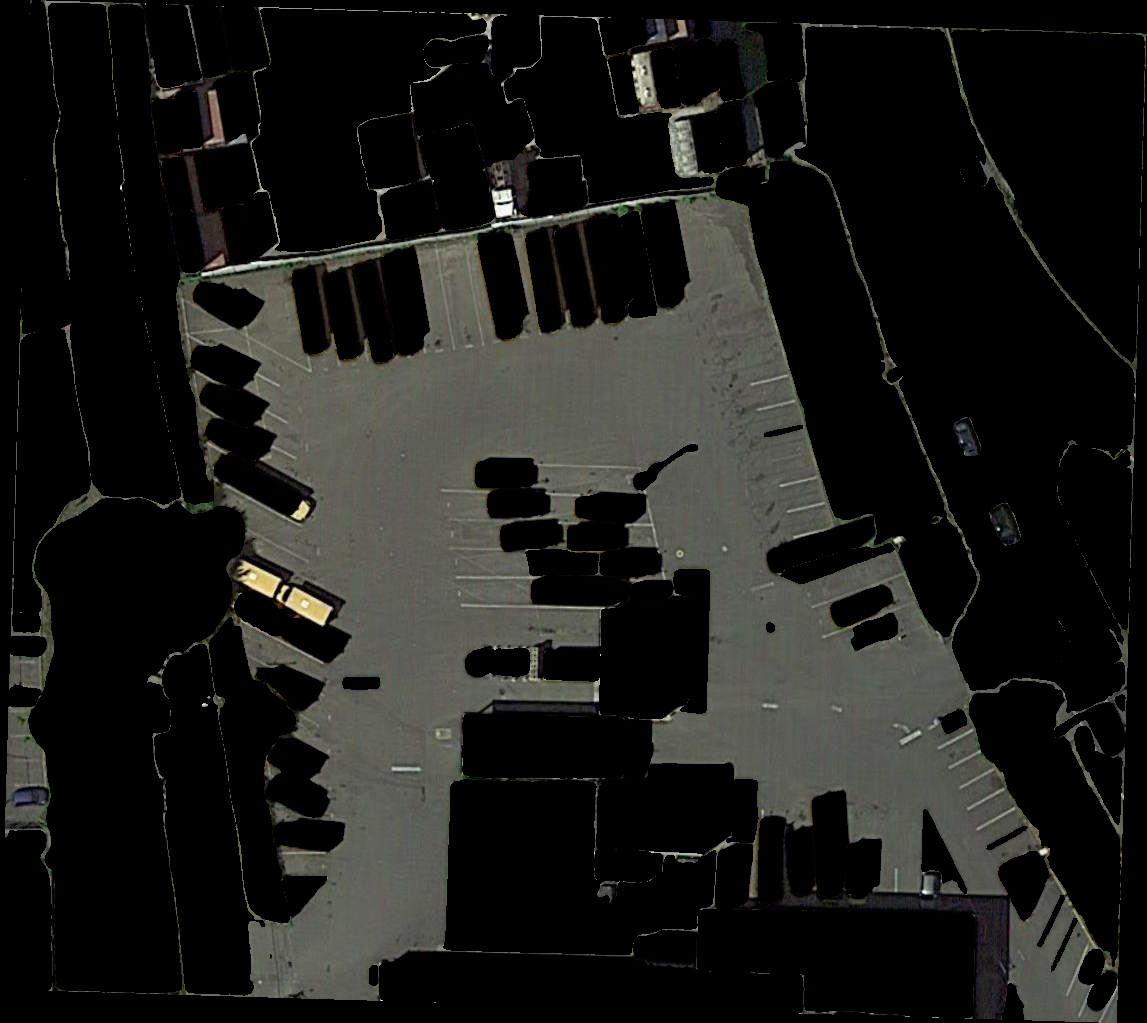

In [56]:
image = Image.open(image_path)
cropped_boxes = []
result = image.copy()

# result = Image.new("RGB", image.size, (255, 255, 255))

for mask in masks:
    # cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    add_segment(result, image, mask["segmentation"])

display(result)